# 2. Process segmented cells (cell type assignment)

Next, we will employ basic scanpy functionalities to identify and annotate the main populations present in the dataset analyzed. This will be useful later on to further understand extracellular transcripts in the context of their surrounding cells

## Import packages

In [3]:
import numpy as np
import pandas as pd
import spatialdata as sd
import scanpy as sc

## Read SpatialData object

We read the processed Spatialdata object, which was previously stored as .zarr

In [4]:
xenium_path_cropped='/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr'
sdata=sd.read_zarr(xenium_path_cropped)

/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/

We aim to identify the main populations present in the dataset. For this, we will process the cell information, stored as AnnData in ``sdata['table']``. To start, we will filter cells and reads, transform the data appropiately

In [5]:
adata=sdata['table']
adata.raw=adata
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata.layers["raw"] = adata.X.copy()
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

After this, we will perform PCA to identify main principal components

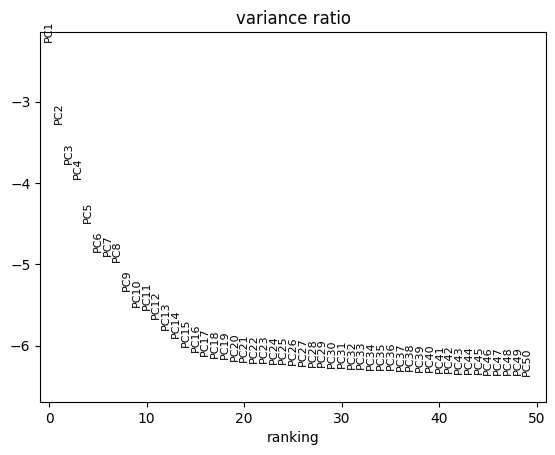

In [6]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

We will compute ``sc.pp.neighbors`` prior to identiying low-dimensional representation via UMAP and clustering the cells with leiden

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata,key_added='leiden')

/home/sergio/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_802420/3950960458.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,key_added='leiden')


We can visualize the populations as it follows:

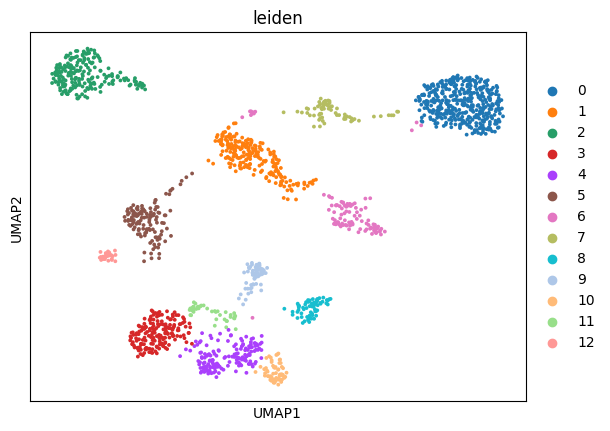

In [8]:
sc.pl.umap(adata,color="leiden",size=30)

Populations can be also visualized spatially:

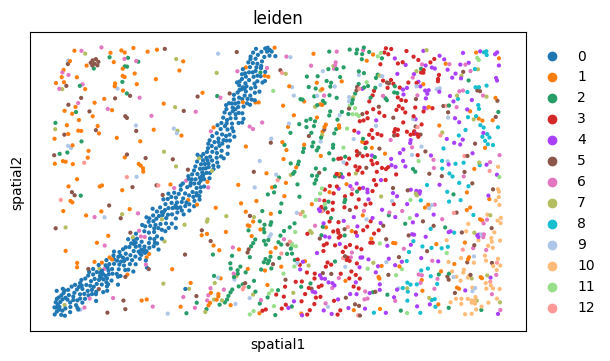

In [9]:
sc.pl.spatial(adata,color='leiden',spot_size=10)

Furthermore, we can identify the main differentially expressed genes between populations using wilcoxon 

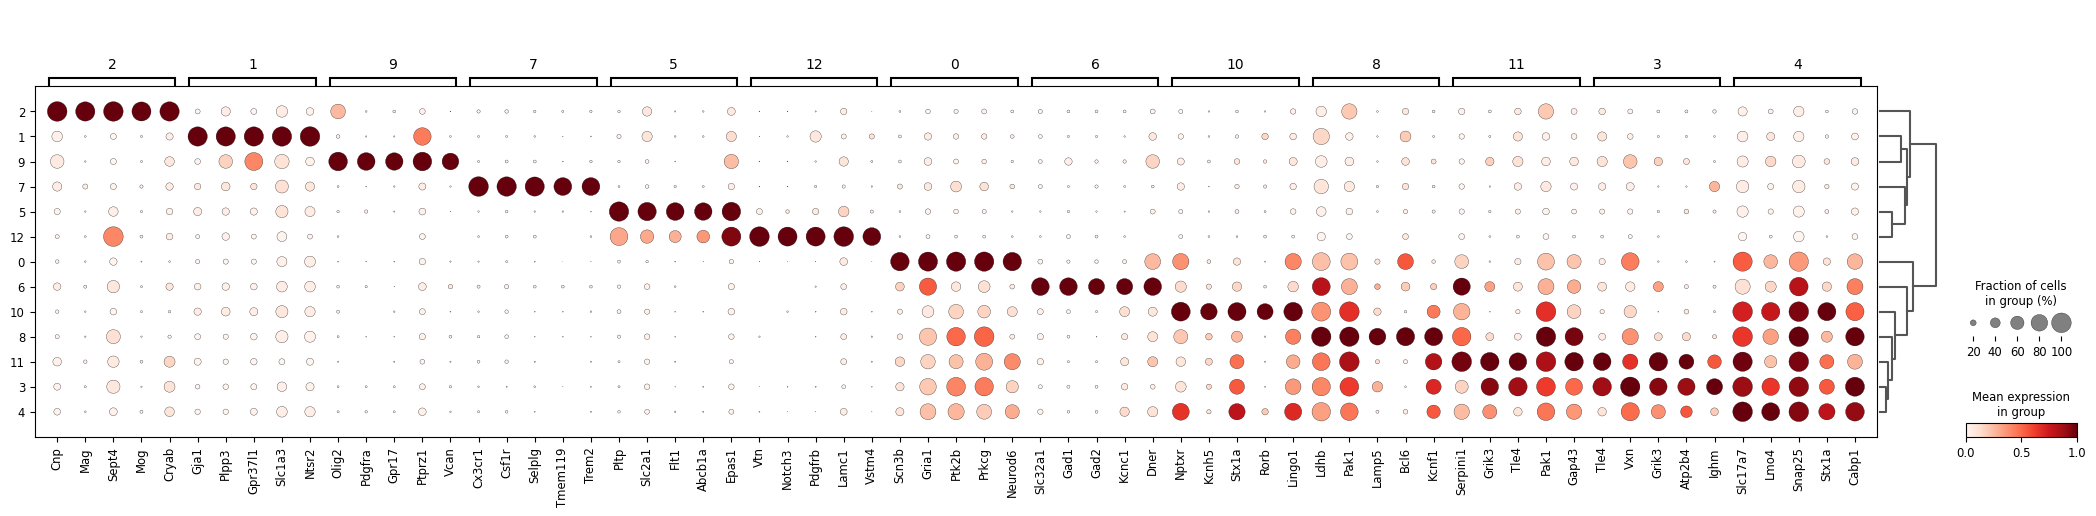

In [10]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups_dotplot(adata, groupby="leiden", standard_scale="var", n_genes=5)

## Annotate segmented cells

Using the location and expression of each population identified, we have annotated them as it follows:

In [11]:
anndict={'0':'CA','1':'Astro','2':'Oligo','3':'Excitatory','4':'Excitatory','5':'Endothelial','6':'Inhibitory',
         '7':'Microglia','8':'Excitatory','9':'OPC','10':'L4 EXC','11':'Excitatory','12':'Pericyte'}
adata.obs['cell type']=adata.obs['leiden'].map(anndict)

## Writting output in zarr

The annotated dataset is finally stored in a new zarr object

In [12]:
xenium_path_cropped='/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions_annotated.zarr'
sdata.write(xenium_path_cropped,overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions_annotated.zarr).     
         Please see the documentation of `is_self_contained()` to understand the implications of working with      
         SpatialData objects that are not self-contained.                                                          
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr the new file path:                
         /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions_annotated.zarr                         
